# WGAN

元論文 : Wasserstein GAN https://arxiv.org/abs/1701.07875 (2017)

WGANはGANのLossを変えることで、数学的に画像生成の学習を良くしよう!っていうもの。

通常のGANはKLDivergenceを使って、Generatorによる確率分布を、生成したい画像の生起分布に近づけていく。だが、KLDでは連続性が保証されないので、代わりにWasserstain距離を用いて、近似していこうというのがWGAN。

Wasserstain距離によるLossを実現するために、WGANのDiscriminatorでは最後にSigmoid関数を適用しない。つまり、LossもSigmoid Cross Entropyでなく、Discriminatorの出力の値をそのまま使う。

WGANのアルゴリズムは、イテレーション毎に以下のDiscriminatorとGeneratorの学習を交互に行っていく。
- 最適化 : RMSProp(LearningRate:0.0005)

#### Discriminatorの学習（以下操作をcriticの数値だけ繰り返す）
1. Real画像と、一様分布からzをサンプリングする
2. Loss $L_D = \frac{1}{|Minibatch|} \{ \sum_{i} D(x^{(i)}) -  \sum_i D (G(z^{(i)})) \}$ を計算し、SGD
3. Discriminatorのパラメータを全て、 [- clip, clip]　にクリッピングする

#### Generatorの学習
1. 一様分布からzをサンプリングする
2. Loss $L_G = \frac{1}{|Minibatch|}  \sum_i D (G(z^{(i)})) $ を計算し、SGD

(WGANは収束がすごく遅い、、学習回数がめちゃくちゃ必要なので、注意！！！！)

## Import and Config

In [7]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 128
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.G_DIM = 64
cfg.D_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'WGAN-GP'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = None

cfg.TRAIN.DATA_PATH = '../../Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# WGAN  config
#---
cfg.TRAIN.WGAN_CLIPS_VALUE = 0.01
cfg.TRAIN.WGAN_CRITIC_N = 5

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '../../Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM, cfg.G_DIM * 4, kernel_size=[cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_WIDTH // 8], stride=1, bias=False),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 4),
            'G_layer_1_ReLU' : torch.nn.ReLU(),
            'G_layer_2' : torch.nn.ConvTranspose2d(cfg.G_DIM * 4, cfg.G_DIM * 2, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_2_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 2),
            'G_layer_2_ReLU' : torch.nn.ReLU(),
            'G_layer_3' : torch.nn.ConvTranspose2d(cfg.G_DIM * 2, cfg.G_DIM, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_3_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_3_ReLU' : torch.nn.ReLU(),
            'G_layer_out' : torch.nn.ConvTranspose2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_out_tanh' : torch.nn.Tanh()
        }))

    def forward(self, x):
        x = self.module(x)
        return x

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, cfg.D_DIM, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_1_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_2' : torch.nn.Conv2d(cfg.D_DIM, cfg.D_DIM * 2, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_2_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 2),
            'D_layer_2_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_3' : torch.nn.Conv2d(cfg.D_DIM * 2, cfg.D_DIM * 4, kernel_size=4, padding=1, stride=2, bias=False),
            'G_layer_3_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 4),
            'D_layer_3_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_out' : torch.nn.Conv2d(cfg.D_DIM * 4, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_WIDTH // 8], padding=0, stride=1, bias=False),
        }))

    def forward(self, x):
        x = self.module(x)
        return x


## Train

100%|██████████| 16/16 [00:00<00:00, 15842.51it/s]

Dataset >> ../../Dataset/train/images/
 - Found data num >> 16
 - Horizontal >> True
 - Vertical >> False
 - Rotation >> False
all data num >> 32
dataset was completely loaded
--
training start


Iter:50, LossG (fake:1.0192), LossD:2.1455 (real:-1.1954, fake:0.9501), WDistance:-2.1454529762268066
Iter:100, LossG (fake:1.0715), LossD:2.2487 (real:-1.2616, fake:0.9872), WDistance:-2.2487123012542725
Iter:150, LossG (fake:0.9813), LossD:2.1947 (real:-1.2218, fake:0.9730), WDistance:-2.194718837738037
Iter:200, LossG (fake:0.9211), LossD:2.0272 (real:-1.1201, fake:0.9071), WDistance:-2.027174472808838
save G >> models/WGAN-GP_G_iter200.pt, D >> models/WGAN-GP_D_iter200.pt
Iter:250, LossG (fake:0.9232), LossD:1.9750 (real:-1.1480, fake:0.8270), WDistance:-1.9749993085861206
Iter:300, LossG (fake:0.8766), LossD:1.9982 (real:-1.1208, fake:0.8774), WDistance:-1.9981759786605835
Iter:350, LossG (fake:0.8487), LossD:1.9490 (real:-1.0991, fake:0.8499), WDistance:-1.949008822441101
Iter:400, LossG (fake:0.8011), LossD:1.8659 (real:-1.0483, fake:0.8177), WDistance:-1.8659281730651855
save G >> models/WGAN-GP_G_iter400.pt, D >> models/WGAN-GP_D_iter400.pt
Iter:450, LossG (fake:0.7993), LossD

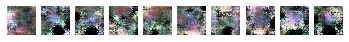

Iter:550, LossG (fake:0.7424), LossD:1.8037 (real:-1.0233, fake:0.7805), WDistance:-1.8037415742874146
Iter:600, LossG (fake:0.7659), LossD:1.5186 (real:-0.9177, fake:0.6009), WDistance:-1.5186494588851929
save G >> models/WGAN-GP_G_iter600.pt, D >> models/WGAN-GP_D_iter600.pt
Iter:650, LossG (fake:0.5720), LossD:1.5414 (real:-0.8409, fake:0.7004), WDistance:-1.541365146636963
Iter:700, LossG (fake:0.5734), LossD:1.4983 (real:-0.8469, fake:0.6514), WDistance:-1.498321771621704
Iter:750, LossG (fake:0.6837), LossD:1.4030 (real:-0.8675, fake:0.5356), WDistance:-1.4030303955078125
Iter:800, LossG (fake:0.6262), LossD:1.4687 (real:-0.7941, fake:0.6746), WDistance:-1.468719720840454
save G >> models/WGAN-GP_G_iter800.pt, D >> models/WGAN-GP_D_iter800.pt
Iter:850, LossG (fake:0.6988), LossD:1.4378 (real:-0.7250, fake:0.7128), WDistance:-1.4377833604812622
Iter:900, LossG (fake:0.8074), LossD:1.6193 (real:-0.8228, fake:0.7965), WDistance:-1.6193151473999023
Iter:950, LossG (fake:0.8608), Loss

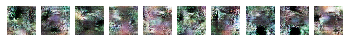

Iter:1050, LossG (fake:0.6577), LossD:1.3951 (real:-0.8390, fake:0.5561), WDistance:-1.3951350450515747
Iter:1100, LossG (fake:0.9258), LossD:1.5912 (real:-0.8365, fake:0.7546), WDistance:-1.5911633968353271
Iter:1150, LossG (fake:0.7573), LossD:1.4100 (real:-0.4886, fake:0.9214), WDistance:-1.410006046295166
Iter:1200, LossG (fake:0.8628), LossD:1.6136 (real:-0.7834, fake:0.8302), WDistance:-1.613629698753357
save G >> models/WGAN-GP_G_iter1200.pt, D >> models/WGAN-GP_D_iter1200.pt
Iter:1250, LossG (fake:0.8384), LossD:1.5916 (real:-0.8753, fake:0.7162), WDistance:-1.5915586948394775
Iter:1300, LossG (fake:0.6284), LossD:1.4441 (real:-0.5772, fake:0.8669), WDistance:-1.4440590143203735
Iter:1350, LossG (fake:0.6708), LossD:1.5672 (real:-0.7134, fake:0.8538), WDistance:-1.5671987533569336
Iter:1400, LossG (fake:0.7535), LossD:1.5708 (real:-0.8115, fake:0.7593), WDistance:-1.5707577466964722
save G >> models/WGAN-GP_G_iter1400.pt, D >> models/WGAN-GP_D_iter1400.pt
Iter:1450, LossG (fake

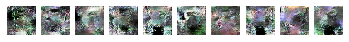

Iter:1550, LossG (fake:0.8482), LossD:1.5655 (real:-0.8462, fake:0.7193), WDistance:-1.565474510192871
Iter:1600, LossG (fake:0.8783), LossD:1.5504 (real:-0.8440, fake:0.7064), WDistance:-1.5504474639892578
save G >> models/WGAN-GP_G_iter1600.pt, D >> models/WGAN-GP_D_iter1600.pt
Iter:1650, LossG (fake:0.7315), LossD:1.5848 (real:-0.8206, fake:0.7642), WDistance:-1.5847797393798828
Iter:1700, LossG (fake:0.8051), LossD:1.6122 (real:-0.8300, fake:0.7822), WDistance:-1.6122419834136963
Iter:1750, LossG (fake:0.7138), LossD:1.5248 (real:-0.7441, fake:0.7808), WDistance:-1.5248024463653564
Iter:1800, LossG (fake:0.5755), LossD:1.4699 (real:-0.6694, fake:0.8005), WDistance:-1.46992027759552
save G >> models/WGAN-GP_G_iter1800.pt, D >> models/WGAN-GP_D_iter1800.pt
Iter:1850, LossG (fake:0.7394), LossD:1.5384 (real:-0.7600, fake:0.7784), WDistance:-1.5384142398834229
Iter:1900, LossG (fake:0.7428), LossD:1.4937 (real:-0.7335, fake:0.7602), WDistance:-1.4936974048614502
Iter:1950, LossG (fake:

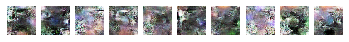

Iter:2050, LossG (fake:0.8413), LossD:1.4997 (real:-0.7610, fake:0.7387), WDistance:-1.4997398853302002
Iter:2100, LossG (fake:0.7860), LossD:1.5342 (real:-0.8412, fake:0.6930), WDistance:-1.5342212915420532
Iter:2150, LossG (fake:0.6910), LossD:1.5696 (real:-0.7714, fake:0.7982), WDistance:-1.5696462392807007
Iter:2200, LossG (fake:0.9223), LossD:1.5064 (real:-0.8001, fake:0.7063), WDistance:-1.5063984394073486
save G >> models/WGAN-GP_G_iter2200.pt, D >> models/WGAN-GP_D_iter2200.pt
Iter:2250, LossG (fake:0.8277), LossD:1.5826 (real:-0.8552, fake:0.7274), WDistance:-1.5826044082641602
Iter:2300, LossG (fake:0.7908), LossD:1.5581 (real:-0.8358, fake:0.7223), WDistance:-1.5580763816833496
Iter:2350, LossG (fake:0.6000), LossD:1.4923 (real:-0.7306, fake:0.7617), WDistance:-1.4923276901245117
Iter:2400, LossG (fake:0.7493), LossD:1.4844 (real:-0.7884, fake:0.6961), WDistance:-1.4844220876693726
save G >> models/WGAN-GP_G_iter2400.pt, D >> models/WGAN-GP_D_iter2400.pt
Iter:2450, LossG (fa

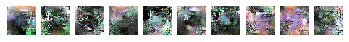

Iter:2550, LossG (fake:0.6770), LossD:1.5274 (real:-0.7627, fake:0.7647), WDistance:-1.5273926258087158
Iter:2600, LossG (fake:0.5510), LossD:1.5246 (real:-0.7658, fake:0.7588), WDistance:-1.5246107578277588
save G >> models/WGAN-GP_G_iter2600.pt, D >> models/WGAN-GP_D_iter2600.pt
Iter:2650, LossG (fake:0.7185), LossD:1.4595 (real:-0.8410, fake:0.6185), WDistance:-1.4594597816467285
Iter:2700, LossG (fake:0.8383), LossD:1.5757 (real:-0.7959, fake:0.7798), WDistance:-1.5757123231887817
Iter:2750, LossG (fake:0.7686), LossD:1.5257 (real:-0.7863, fake:0.7394), WDistance:-1.5256613492965698
Iter:2800, LossG (fake:0.7029), LossD:1.5010 (real:-0.6977, fake:0.8033), WDistance:-1.5010255575180054
save G >> models/WGAN-GP_G_iter2800.pt, D >> models/WGAN-GP_D_iter2800.pt
Iter:2850, LossG (fake:0.8091), LossD:1.5693 (real:-0.8510, fake:0.7183), WDistance:-1.5693435668945312
Iter:2900, LossG (fake:0.7160), LossD:1.5191 (real:-0.7748, fake:0.7443), WDistance:-1.519115924835205
Iter:2950, LossG (fak

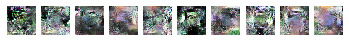

Iter:3050, LossG (fake:0.5937), LossD:1.3913 (real:-0.8164, fake:0.5749), WDistance:-1.3913195133209229
Iter:3100, LossG (fake:0.8317), LossD:1.5370 (real:-0.8132, fake:0.7238), WDistance:-1.5370128154754639
Iter:3150, LossG (fake:0.7309), LossD:1.5426 (real:-0.7929, fake:0.7498), WDistance:-1.542638897895813
Iter:3200, LossG (fake:0.7347), LossD:1.5401 (real:-0.8304, fake:0.7097), WDistance:-1.5401291847229004
save G >> models/WGAN-GP_G_iter3200.pt, D >> models/WGAN-GP_D_iter3200.pt
Iter:3250, LossG (fake:0.8413), LossD:1.5219 (real:-0.8696, fake:0.6524), WDistance:-1.5219471454620361
Iter:3300, LossG (fake:0.7452), LossD:1.5376 (real:-0.7744, fake:0.7632), WDistance:-1.5375784635543823
Iter:3350, LossG (fake:0.8274), LossD:1.5062 (real:-0.7610, fake:0.7452), WDistance:-1.5062034130096436
Iter:3400, LossG (fake:0.7365), LossD:1.5291 (real:-0.7887, fake:0.7404), WDistance:-1.529145359992981
save G >> models/WGAN-GP_G_iter3400.pt, D >> models/WGAN-GP_D_iter3400.pt
Iter:3450, LossG (fake

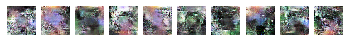

Iter:3550, LossG (fake:0.7523), LossD:1.4375 (real:-0.7578, fake:0.6797), WDistance:-1.4374990463256836
Iter:3600, LossG (fake:0.7995), LossD:1.5422 (real:-0.8433, fake:0.6990), WDistance:-1.5422474145889282
save G >> models/WGAN-GP_G_iter3600.pt, D >> models/WGAN-GP_D_iter3600.pt
Iter:3650, LossG (fake:0.7891), LossD:1.5287 (real:-0.7835, fake:0.7451), WDistance:-1.5286650657653809
Iter:3700, LossG (fake:0.7694), LossD:1.4623 (real:-0.8358, fake:0.6265), WDistance:-1.462338924407959
Iter:3750, LossG (fake:0.7455), LossD:1.5497 (real:-0.7885, fake:0.7612), WDistance:-1.5497326850891113
Iter:3800, LossG (fake:0.7232), LossD:1.4666 (real:-0.7065, fake:0.7601), WDistance:-1.466594934463501
save G >> models/WGAN-GP_G_iter3800.pt, D >> models/WGAN-GP_D_iter3800.pt
Iter:3850, LossG (fake:0.8379), LossD:1.5687 (real:-0.8401, fake:0.7286), WDistance:-1.5686558485031128
Iter:3900, LossG (fake:0.6841), LossD:1.5061 (real:-0.7049, fake:0.8012), WDistance:-1.5060503482818604
Iter:3950, LossG (fake

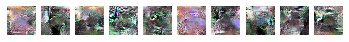

Iter:4050, LossG (fake:0.7248), LossD:1.5673 (real:-0.8032, fake:0.7641), WDistance:-1.5672717094421387
Iter:4100, LossG (fake:0.8259), LossD:1.5533 (real:-0.8490, fake:0.7043), WDistance:-1.5532552003860474
Iter:4150, LossG (fake:0.7725), LossD:1.4407 (real:-0.7025, fake:0.7383), WDistance:-1.440732717514038
Iter:4200, LossG (fake:0.7395), LossD:1.5390 (real:-0.7660, fake:0.7730), WDistance:-1.538993000984192
save G >> models/WGAN-GP_G_iter4200.pt, D >> models/WGAN-GP_D_iter4200.pt
Iter:4250, LossG (fake:0.7963), LossD:1.4657 (real:-0.6864, fake:0.7794), WDistance:-1.465726613998413
Iter:4300, LossG (fake:0.7322), LossD:1.5363 (real:-0.7647, fake:0.7716), WDistance:-1.536259412765503
Iter:4350, LossG (fake:0.7414), LossD:1.5092 (real:-0.7574, fake:0.7518), WDistance:-1.5092246532440186
Iter:4400, LossG (fake:0.7671), LossD:1.5366 (real:-0.7507, fake:0.7859), WDistance:-1.536606788635254
save G >> models/WGAN-GP_G_iter4400.pt, D >> models/WGAN-GP_D_iter4400.pt
Iter:4450, LossG (fake:0.

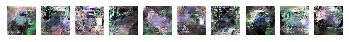

Iter:4550, LossG (fake:0.7800), LossD:1.5405 (real:-0.8308, fake:0.7097), WDistance:-1.5404589176177979
Iter:4600, LossG (fake:0.8224), LossD:1.5500 (real:-0.8431, fake:0.7069), WDistance:-1.5499980449676514
save G >> models/WGAN-GP_G_iter4600.pt, D >> models/WGAN-GP_D_iter4600.pt
Iter:4650, LossG (fake:0.7981), LossD:1.4974 (real:-0.7933, fake:0.7041), WDistance:-1.497415542602539
Iter:4700, LossG (fake:0.8080), LossD:1.4509 (real:-0.7337, fake:0.7173), WDistance:-1.4509453773498535
Iter:4750, LossG (fake:0.7475), LossD:1.5193 (real:-0.7884, fake:0.7309), WDistance:-1.51930570602417
Iter:4800, LossG (fake:0.6951), LossD:1.5102 (real:-0.7429, fake:0.7673), WDistance:-1.5101566314697266
save G >> models/WGAN-GP_G_iter4800.pt, D >> models/WGAN-GP_D_iter4800.pt
Iter:4850, LossG (fake:0.8258), LossD:1.5342 (real:-0.8792, fake:0.6550), WDistance:-1.5342094898223877
Iter:4900, LossG (fake:0.7071), LossD:1.4727 (real:-0.6719, fake:0.8008), WDistance:-1.472747802734375
Iter:4950, LossG (fake:0

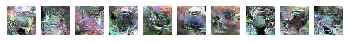

Iter:5050, LossG (fake:0.7153), LossD:1.4973 (real:-0.7165, fake:0.7808), WDistance:-1.497319221496582
Iter:5100, LossG (fake:0.8164), LossD:1.5173 (real:-0.7693, fake:0.7480), WDistance:-1.5173194408416748
Iter:5150, LossG (fake:0.7353), LossD:1.4704 (real:-0.6508, fake:0.8196), WDistance:-1.4703681468963623
Iter:5200, LossG (fake:0.8147), LossD:1.5155 (real:-0.8536, fake:0.6619), WDistance:-1.5155278444290161
save G >> models/WGAN-GP_G_iter5200.pt, D >> models/WGAN-GP_D_iter5200.pt
Iter:5250, LossG (fake:0.8298), LossD:1.5251 (real:-0.8433, fake:0.6817), WDistance:-1.5250593423843384
Iter:5300, LossG (fake:0.7337), LossD:1.5532 (real:-0.7688, fake:0.7845), WDistance:-1.5532338619232178
Iter:5350, LossG (fake:0.7703), LossD:1.5147 (real:-0.7552, fake:0.7595), WDistance:-1.514748454093933
Iter:5400, LossG (fake:0.7659), LossD:1.5434 (real:-0.8469, fake:0.6965), WDistance:-1.5433969497680664
save G >> models/WGAN-GP_G_iter5400.pt, D >> models/WGAN-GP_D_iter5400.pt
Iter:5450, LossG (fake

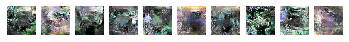

Iter:5550, LossG (fake:0.8078), LossD:1.5056 (real:-0.7958, fake:0.7098), WDistance:-1.5056283473968506
Iter:5600, LossG (fake:0.7673), LossD:1.4921 (real:-0.7592, fake:0.7329), WDistance:-1.492141604423523
save G >> models/WGAN-GP_G_iter5600.pt, D >> models/WGAN-GP_D_iter5600.pt
Iter:5650, LossG (fake:0.7974), LossD:1.4781 (real:-0.8610, fake:0.6172), WDistance:-1.4781417846679688
Iter:5700, LossG (fake:0.7181), LossD:1.4814 (real:-0.7522, fake:0.7291), WDistance:-1.4813709259033203
Iter:5750, LossG (fake:0.7255), LossD:1.4393 (real:-0.7072, fake:0.7321), WDistance:-1.4393247365951538
Iter:5800, LossG (fake:0.7057), LossD:1.5013 (real:-0.7693, fake:0.7320), WDistance:-1.5013264417648315
save G >> models/WGAN-GP_G_iter5800.pt, D >> models/WGAN-GP_D_iter5800.pt
Iter:5850, LossG (fake:0.7747), LossD:1.5191 (real:-0.8114, fake:0.7077), WDistance:-1.5190858840942383
Iter:5900, LossG (fake:0.8633), LossD:1.4982 (real:-0.8037, fake:0.6944), WDistance:-1.4981560707092285
Iter:5950, LossG (fak

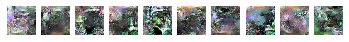

Iter:6050, LossG (fake:0.6544), LossD:1.4897 (real:-0.7482, fake:0.7415), WDistance:-1.4897220134735107
Iter:6100, LossG (fake:0.6889), LossD:1.4713 (real:-0.8091, fake:0.6622), WDistance:-1.4712750911712646
Iter:6150, LossG (fake:0.7427), LossD:1.5149 (real:-0.8027, fake:0.7122), WDistance:-1.5149474143981934
Iter:6200, LossG (fake:0.7993), LossD:1.5041 (real:-0.7968, fake:0.7073), WDistance:-1.5041413307189941
save G >> models/WGAN-GP_G_iter6200.pt, D >> models/WGAN-GP_D_iter6200.pt
Iter:6250, LossG (fake:0.7658), LossD:1.5131 (real:-0.8171, fake:0.6960), WDistance:-1.513085126876831
Iter:6300, LossG (fake:0.8540), LossD:1.5274 (real:-0.8074, fake:0.7200), WDistance:-1.5274078845977783
Iter:6350, LossG (fake:0.7403), LossD:1.4222 (real:-0.7326, fake:0.6896), WDistance:-1.4222030639648438
Iter:6400, LossG (fake:0.7932), LossD:1.5061 (real:-0.8124, fake:0.6937), WDistance:-1.5061191320419312
save G >> models/WGAN-GP_G_iter6400.pt, D >> models/WGAN-GP_D_iter6400.pt
Iter:6450, LossG (fak

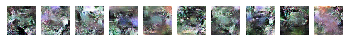

Iter:6550, LossG (fake:0.6300), LossD:1.4972 (real:-0.7934, fake:0.7038), WDistance:-1.497209072113037
Iter:6600, LossG (fake:0.7904), LossD:1.4549 (real:-0.7765, fake:0.6785), WDistance:-1.4549427032470703
save G >> models/WGAN-GP_G_iter6600.pt, D >> models/WGAN-GP_D_iter6600.pt
Iter:6650, LossG (fake:0.6486), LossD:1.4825 (real:-0.6995, fake:0.7830), WDistance:-1.4824976921081543
Iter:6700, LossG (fake:0.8277), LossD:1.5493 (real:-0.8187, fake:0.7306), WDistance:-1.5493332147598267
Iter:6750, LossG (fake:0.7305), LossD:1.5507 (real:-0.8016, fake:0.7491), WDistance:-1.55072021484375
Iter:6800, LossG (fake:0.8363), LossD:1.5526 (real:-0.8162, fake:0.7363), WDistance:-1.55256187915802
save G >> models/WGAN-GP_G_iter6800.pt, D >> models/WGAN-GP_D_iter6800.pt
Iter:6850, LossG (fake:0.8538), LossD:1.5484 (real:-0.8163, fake:0.7321), WDistance:-1.5484429597854614
Iter:6900, LossG (fake:0.7928), LossD:1.4882 (real:-0.7903, fake:0.6979), WDistance:-1.488249659538269
Iter:6950, LossG (fake:0.7

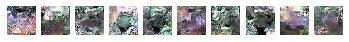

Iter:7050, LossG (fake:0.7368), LossD:1.4672 (real:-0.7413, fake:0.7259), WDistance:-1.4671928882598877
Iter:7100, LossG (fake:0.8277), LossD:1.3842 (real:-0.8158, fake:0.5684), WDistance:-1.3841991424560547
Iter:7150, LossG (fake:0.7507), LossD:1.4788 (real:-0.8032, fake:0.6756), WDistance:-1.4788047075271606
Iter:7200, LossG (fake:0.7646), LossD:1.5467 (real:-0.7608, fake:0.7859), WDistance:-1.5466891527175903
save G >> models/WGAN-GP_G_iter7200.pt, D >> models/WGAN-GP_D_iter7200.pt
Iter:7250, LossG (fake:0.7824), LossD:1.4149 (real:-0.8030, fake:0.6119), WDistance:-1.4149017333984375
Iter:7300, LossG (fake:0.7348), LossD:1.5741 (real:-0.8065, fake:0.7677), WDistance:-1.5741171836853027
Iter:7350, LossG (fake:0.8409), LossD:1.5123 (real:-0.8374, fake:0.6749), WDistance:-1.5123190879821777
Iter:7400, LossG (fake:0.6313), LossD:1.4859 (real:-0.7119, fake:0.7740), WDistance:-1.4859118461608887
save G >> models/WGAN-GP_G_iter7400.pt, D >> models/WGAN-GP_D_iter7400.pt
Iter:7450, LossG (fa

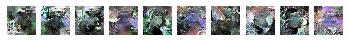

Iter:7550, LossG (fake:0.7799), LossD:1.5239 (real:-0.7702, fake:0.7537), WDistance:-1.5238605737686157
Iter:7600, LossG (fake:0.6077), LossD:1.4233 (real:-0.6488, fake:0.7745), WDistance:-1.4232959747314453
save G >> models/WGAN-GP_G_iter7600.pt, D >> models/WGAN-GP_D_iter7600.pt
Iter:7650, LossG (fake:0.7099), LossD:1.4178 (real:-0.6882, fake:0.7296), WDistance:-1.4178013801574707
Iter:7700, LossG (fake:0.7866), LossD:1.4388 (real:-0.7978, fake:0.6410), WDistance:-1.438799500465393
Iter:7750, LossG (fake:0.7944), LossD:1.5440 (real:-0.7886, fake:0.7554), WDistance:-1.5440073013305664
Iter:7800, LossG (fake:0.7202), LossD:1.4896 (real:-0.7520, fake:0.7376), WDistance:-1.4895751476287842
save G >> models/WGAN-GP_G_iter7800.pt, D >> models/WGAN-GP_D_iter7800.pt
Iter:7850, LossG (fake:0.7258), LossD:1.5015 (real:-0.6931, fake:0.8084), WDistance:-1.5015100240707397
Iter:7900, LossG (fake:0.6827), LossD:1.4868 (real:-0.7099, fake:0.7769), WDistance:-1.486762523651123
Iter:7950, LossG (fake

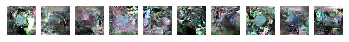

Iter:8050, LossG (fake:0.7706), LossD:1.5561 (real:-0.8069, fake:0.7492), WDistance:-1.556145191192627
Iter:8100, LossG (fake:0.7024), LossD:1.5092 (real:-0.7560, fake:0.7532), WDistance:-1.5091969966888428
Iter:8150, LossG (fake:0.7245), LossD:1.4853 (real:-0.7062, fake:0.7792), WDistance:-1.485335111618042
Iter:8200, LossG (fake:0.7555), LossD:1.5433 (real:-0.7907, fake:0.7526), WDistance:-1.5432965755462646
save G >> models/WGAN-GP_G_iter8200.pt, D >> models/WGAN-GP_D_iter8200.pt
Iter:8250, LossG (fake:0.7116), LossD:1.4885 (real:-0.7474, fake:0.7411), WDistance:-1.4884765148162842
Iter:8300, LossG (fake:0.6989), LossD:1.4368 (real:-0.6722, fake:0.7646), WDistance:-1.4367833137512207
Iter:8350, LossG (fake:0.8219), LossD:1.5160 (real:-0.7375, fake:0.7784), WDistance:-1.5159564018249512
Iter:8400, LossG (fake:0.8120), LossD:1.5193 (real:-0.7837, fake:0.7356), WDistance:-1.5193208456039429
save G >> models/WGAN-GP_G_iter8400.pt, D >> models/WGAN-GP_D_iter8400.pt
Iter:8450, LossG (fake

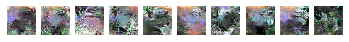

Iter:8550, LossG (fake:0.8365), LossD:1.5538 (real:-0.8129, fake:0.7410), WDistance:-1.5538420677185059
Iter:8600, LossG (fake:0.7025), LossD:1.5103 (real:-0.7665, fake:0.7438), WDistance:-1.510324239730835
save G >> models/WGAN-GP_G_iter8600.pt, D >> models/WGAN-GP_D_iter8600.pt
Iter:8650, LossG (fake:0.7984), LossD:1.5136 (real:-0.8387, fake:0.6749), WDistance:-1.5135846138000488
Iter:8700, LossG (fake:0.7183), LossD:1.5286 (real:-0.7285, fake:0.8001), WDistance:-1.528613567352295
Iter:8750, LossG (fake:0.7524), LossD:1.4369 (real:-0.8257, fake:0.6112), WDistance:-1.4369282722473145
Iter:8800, LossG (fake:0.8055), LossD:1.5133 (real:-0.8014, fake:0.7120), WDistance:-1.5133334398269653
save G >> models/WGAN-GP_G_iter8800.pt, D >> models/WGAN-GP_D_iter8800.pt
Iter:8850, LossG (fake:0.6788), LossD:1.4839 (real:-0.7059, fake:0.7780), WDistance:-1.4838913679122925
Iter:8900, LossG (fake:0.7939), LossD:1.5445 (real:-0.7714, fake:0.7731), WDistance:-1.544501781463623
Iter:8950, LossG (fake:

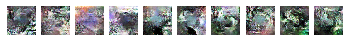

Iter:9050, LossG (fake:0.7088), LossD:1.4694 (real:-0.7243, fake:0.7451), WDistance:-1.469350814819336
Iter:9100, LossG (fake:0.6611), LossD:1.4978 (real:-0.7169, fake:0.7809), WDistance:-1.4978227615356445
Iter:9150, LossG (fake:0.8345), LossD:1.4968 (real:-0.8031, fake:0.6937), WDistance:-1.4968392848968506
Iter:9200, LossG (fake:0.7404), LossD:1.5205 (real:-0.7448, fake:0.7757), WDistance:-1.5205061435699463
save G >> models/WGAN-GP_G_iter9200.pt, D >> models/WGAN-GP_D_iter9200.pt
Iter:9250, LossG (fake:0.8299), LossD:1.5354 (real:-0.7943, fake:0.7411), WDistance:-1.5353996753692627
Iter:9300, LossG (fake:0.8119), LossD:1.5672 (real:-0.8051, fake:0.7620), WDistance:-1.5671589374542236
Iter:9350, LossG (fake:0.6749), LossD:1.4581 (real:-0.6841, fake:0.7740), WDistance:-1.4581071138381958
Iter:9400, LossG (fake:0.7813), LossD:1.4714 (real:-0.7587, fake:0.7127), WDistance:-1.4714469909667969
save G >> models/WGAN-GP_G_iter9400.pt, D >> models/WGAN-GP_D_iter9400.pt
Iter:9450, LossG (fak

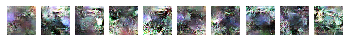

Iter:9550, LossG (fake:0.7133), LossD:1.5395 (real:-0.7735, fake:0.7659), WDistance:-1.5394705533981323
Iter:9600, LossG (fake:0.8110), LossD:1.4980 (real:-0.7649, fake:0.7331), WDistance:-1.4979825019836426
save G >> models/WGAN-GP_G_iter9600.pt, D >> models/WGAN-GP_D_iter9600.pt
Iter:9650, LossG (fake:0.7515), LossD:1.4799 (real:-0.7315, fake:0.7483), WDistance:-1.479859709739685
Iter:9700, LossG (fake:0.7882), LossD:1.4941 (real:-0.7333, fake:0.7608), WDistance:-1.494125247001648
Iter:9750, LossG (fake:0.7527), LossD:1.4358 (real:-0.7975, fake:0.6382), WDistance:-1.4357788562774658
Iter:9800, LossG (fake:0.6908), LossD:1.4674 (real:-0.6639, fake:0.8035), WDistance:-1.4674055576324463
save G >> models/WGAN-GP_G_iter9800.pt, D >> models/WGAN-GP_D_iter9800.pt
Iter:9850, LossG (fake:0.7510), LossD:1.4917 (real:-0.7973, fake:0.6944), WDistance:-1.4917216300964355
Iter:9900, LossG (fake:0.8130), LossD:1.5106 (real:-0.8109, fake:0.6998), WDistance:-1.510645866394043
Iter:9950, LossG (fake:

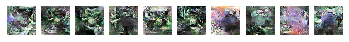

final paramters were saved to G >> models/WGAN-GP_G_final.pt, D >> models/WGAN-GP_D_final.pt
loss was saved to >> result/WGAN-GP_loss.txt


In [5]:
def result_show(G, z, path=None, save=False, show=False):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()

# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict = data_load(cfg)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']

    # training
    mbi = 0
    train_N = len(paths)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []
    list_loss_WDistance = []

    one = torch.FloatTensor([1])
    minus_one = one * -1

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        for _ in range(cfg.TRAIN.WGAN_CRITIC_N):
            opt_D.zero_grad()

            # parameter clipping > [-clip_value, clip_value]
            for param in D.parameters():
                param.data.clamp_(- cfg.TRAIN.WGAN_CLIPS_VALUE, cfg.TRAIN.WGAN_CLIPS_VALUE)

            # sample X
            Xs = torch.tensor(get_image(paths[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # forward
            Gz = G(z)
            loss_D_fake = D(Gz).mean(0).view(1)
            loss_D_real = D(Xs).mean(0).view(1)
            loss_D = loss_D_fake - loss_D_real
            loss_D_real.backward(one)
            loss_D_fake.backward(minus_one)
            opt_D.step()
            Wasserstein_distance = loss_D_real - loss_D_fake

        # update G
        opt_G.zero_grad()
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        loss_G = D(G(z)).mean(0).view(1)
        loss_G.backward(one)
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()
        _Wasserstein_distance = Wasserstein_distance.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                list_loss_WDistance.append(_Wasserstein_distance)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f}), WDistance:{:.4f}'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake, _Wasserstein_distance))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake, 'Wasserstein_Distance' : list_loss_WDistance})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------
result was saved to >> result/WGAN-GP_result_1.jpg


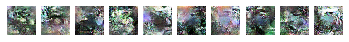

result was saved to >> result/WGAN-GP_result_2.jpg


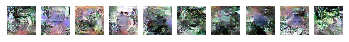

In [6]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True)

test()

In [ ]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
